## Red neuronal para predicción de alquiler de bicicletas

- Diryon Yonith Mora Romero
- Laura Valentina Gonzalez Rodriguez


Construiremos una red neuronal, esta vez para un problema de regresión: predicción de la cantidad de bicicletas alquiladas, según el conjunto de datos *bikeshare_hour*, el cuál se proveerá. Adicionalmente, en esta ocasión encontraremos el mejor modelo usando un conjunto de validación.

Cargar en formato .ipynb o .html en aulas a más tardar el día lunes 17 de marzo.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data 
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset

### Cargar y preparar los datos

Un paso muy importante en redes neuronales es preparar correctamente los datos. Variables con diferentes escalas le dificulta a la red aprender eficientemente los pesos correctos. 


In [23]:
df=pd.read_csv('bikeshare_hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Este dataset contiene el número de alquileres para cada hora de cada día desde Enero 1 de 2011 hasta Diciembre 31 de 2012. El número de usuarios que alquilaron se divide en regitrados *(registered)* y casuales *(casual)*, los cuales se suman en la columna *cnt*, la cuál será nuestra variable objetivo.


Los fines de semana tienen un número más bajo de alquileres y hay picos cuando las personas se dirigen desde y hacia el trabajo durante la semana También tenemos información acerca de la temperatura, humedad, velocidad del viento, todas estas afectando el npumero de alquileres. Trataremos de capturar esta información con nuestro modelo.



<Axes: xlabel='dteday'>

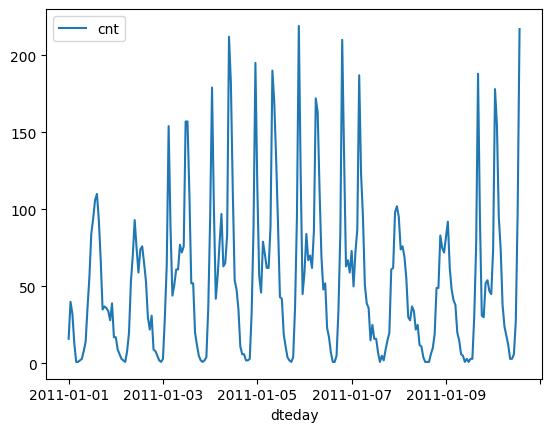

In [24]:
df[:24*10].plot(x='dteday', y='cnt')

Hay algunas variables categóricas: **season**, **weathersit**, **mnth**, **hr**, **weekday**. Nevesitamos crear variables dummy para éstas. 

Así mismo, eliminaremos algunas variables que redundan o no aportan para el modelamiento el modelamiento: **instant**, **dteday**, **atemp**, **workingday**,**registered**, **casual** así como las **columnas originales de las variables que convertimos en dummies** si es necesario.

In [25]:
# TO_DO1 Crear las variables dummies indicadas, y eliminar los atributos indicados
df = pd.get_dummies(df, columns=["season","weathersit","mnth", "hr", "weekday"])
df = df.drop(columns=["instant", "dteday", "atemp", "workingday", "registered", "casual"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 57 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            17379 non-null  int64  
 1   holiday       17379 non-null  int64  
 2   temp          17379 non-null  float64
 3   hum           17379 non-null  float64
 4   windspeed     17379 non-null  float64
 5   cnt           17379 non-null  int64  
 6   season_1      17379 non-null  uint8  
 7   season_2      17379 non-null  uint8  
 8   season_3      17379 non-null  uint8  
 9   season_4      17379 non-null  uint8  
 10  weathersit_1  17379 non-null  uint8  
 11  weathersit_2  17379 non-null  uint8  
 12  weathersit_3  17379 non-null  uint8  
 13  weathersit_4  17379 non-null  uint8  
 14  mnth_1        17379 non-null  uint8  
 15  mnth_2        17379 non-null  uint8  
 16  mnth_3        17379 non-null  uint8  
 17  mnth_4        17379 non-null  uint8  
 18  mnth_5        17379 non-nu

#### Cambiar la escala en variables cuantitativas (normalizar).
Para que el entrenamiento sea más fácil, estandarizaremos los datos de las variables contínuas, de manera que tengan media 0 y desviación estandar 1. 

Para esto, en las columnas de variables contínuas usamos la media y desviación estandar de la respectiva columna

$$col:=\frac{col-mean}{standardeviation}$$ 

In [26]:
# TO_DO 2 Estandarizar las columnas cuantitativas: cnt, temp, hum, windspeed.
original_data = {}
for column in df.filter(regex='cnt|temp|hum|windspeed').columns:
    mean = np.mean(df[column])
    std = np.std(df[column])
    original_data[column] = {"mean": mean, "std": std}
    df[column] = (df[column] - mean) / std
df.head()

,yr,holiday,temp,hum,windspeed,cnt,season_1,season_2,season_3,season_4,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,-1.334648,0.947372,-1.553889,-0.956339,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,-1.438516,0.895539,-1.553889,-0.824022,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,-1.438516,0.895539,-1.553889,-0.868128,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,-1.334648,0.636370,-1.553889,-0.972879,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,-1.334648,0.636370,-1.553889,-1.039037,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Crear conjuntos de entrenamiento, validación y test

En esta ocasión seleccionaremos los conjuntos de entrenamiento, validación y test de forma ordenada. Para el test, seleccionaer los datos de aproximadamente los últimos 21 días. Para el conjunto de validación, tomar los datos de aproximadamente los últimos 60 días de los datos restantes.

In [27]:
# TO_DO3 Definir los conjuntos de train, test y validation. Darles los nombres train, val, test.
train = df
test = df[(df['yr']==1) & (df['mnth_12']==1)] # Ultimo mes
val = df[(df['yr'] == 1) & ((df['mnth_12'] == 1) | (df['mnth_11'] == 1))] # Ultimos dos meses

#### Convertir los datos a tensores y prepararlos para alimentar la red
A continuación  crearemos una clase (*MyDataset*) que nos prepara los datos para alimentar la red neuronal, convirtiendolos a parejas ordenadas de tensores conteniento los atributos y la variable objetivo. Sus parámetros son: el dataset df y el nombre de la columna objetivo en el dataset.


In [28]:
class MyDataset(Dataset):
 
  def __init__(self,df,target_column):
    #price_df=pd.read_csv(file_name)
 
    #x=price_df.iloc[:,0:8].values
    #y=price_df.iloc[:,8].values
    # y_train = df_train['activity']
    # X_train = 
    super()
    y=df[target_column].values
    X=df.drop(target_column,axis=1).values
    self.X=torch.tensor(X,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.float32)
 
  def __len__(self):
    return len(self.y)
   
  def __getitem__(self,idx):
    return self.X[idx],self.y[idx]

Ahora usamos los Dataloaders para los conjuntos set, val y test.

In [29]:
# Usar la clase MyDataset para preparar cada conjunto en forma de tensores
train_sec=MyDataset(train,'cnt')
test_sec=MyDataset(test,'cnt')
val_sec=MyDataset(val,'cnt')

In [30]:
# Definir los DataLoaders para cargar la información pro lotes
train_data=DataLoader(
    train_sec,
    batch_size=1,
    shuffle=False,
    #num_workers=0,
    #collate_fn=None,
    #pin_memory=False,
)

test_data=DataLoader(
    test_sec,
    batch_size=3,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
)

val_data=DataLoader(
    val_sec,
    batch_size=3,
    shuffle=False,
    num_workers=0,
    collate_fn=None,
    pin_memory=False,
)

Vamos a imprimir el primer bath del Test Set para visualizar y entender, sus tamaños y cómo el Dataloader ingresan los datos a la red neuronal.

In [31]:
for i, (data, labels) in enumerate(train_data):
  print(data.shape, labels.shape)
  print(data,labels)
  break

torch.Size([1, 56]) torch.Size([1])
tensor([[ 0.0000,  0.0000, -1.3346,  0.9474, -1.5539,  1.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000]]) tensor([-0.9563])


### Definir la classe Net con la estructura de la red neuronal

Basándose en el taller pasado, construya una red neuronal que tenga las siguientes características: 
- Una sola capa oculta. Usted decida el número de nodos. (Puede hacer entrenamientos pequeños, con una sola epoch por ejemplo, para hacer pruebas y decidir un buen número de nodos. Entre más nodos aprenderá más características de los datos, pero tardará más. Busque un buen equilibrio).
- Una función de activación signoide para la capa oculta.







In [32]:
# TO_DO 4 Escribir el código para la arquitectura de la red neuronal.

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.sigmoid(out)
        out = self.fc2(out)
        return out

Revisamos que estemos usando GPU y definimos el dispositivo 

In [33]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? False


In [34]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cpu


Definimos el modelo, el optimizadoy y la función de costo.

In [35]:
input_size = 56
output_size = 1
hidden_size = 2 * input_size // 3 + output_size

model=Net(input_size, hidden_size, output_size)

#TO_DO 5 Definir el optimizador Stochastic gradient descent y la función MeanSquareError. Usar Learnig rate de 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

##### Por qué se uso un learning rate de 0.01 y no de 0.1.

Inicialmente, se había definido un learning rate (lr) de 0.1 para el optimizador de gradiente estocástico (SGD) en el código. Sin embargo, después de entrenar el modelo, se notó que estaba aprendiendo demasiado rápido, lo que resultaba en un modelo que no se ajustaba bien a los datos (underfitting). Además, un learning rate alto puede provocar overfitting, ya que el modelo converge demasiado rápido a un MSE fijo y no logra generalizar bien a nuevos datos.

Por lo tanto, se decidió disminuir el lr de 0.1 a 0.01 para mejorar el ajuste del modelo a los datos y evitar overfitting. Se optó por un valor intermedio, ya que un lr muy bajo también puede provocar overfitting, ya que el modelo aprende demasiado lento y solo puede ajustarse bien a los datos de entrenamiento y no generaliza bien a nuevos datos. En general, para el SGD se recomienda un lr entre 0.1 y 0.01, por lo que se eligió el valor de 0.01 para este caso.

### Entrenando la red y guardando el mejor modelo

A continuación definimos la función de entrenamiento.

In [36]:
#pasamos el modelo al dispositivo GPU
model.to(device)
def train_model(model,optimizer,loss_module,train_loader,valid_loader,num_epochs):
  
  valid_loss_min =np.inf  #Vamos a encontrar el menor valor de error de validación. Por eso la inicializmaos como 'infinito'
  
  for i in range(num_epochs):
    model.train()  #ponemos el modelo en modo entrenamiento. Es importante en otras arquitecturas como redes convolucionales.
    train_loss = 0.0
    v_loss = 0.0

    # TODO 6 Completar el código a continuación
    for data, target in train_loader:
        target = target.unsqueeze(1)
        # mover los tensores de atributos y etiquetas al dispositivo GPU
        data, target = data.to(device), target.to(device)
        # Reiniciar los gradientes
        optimizer.zero_grad()
        # forward pass: calcular la salida para los datos de entrada..
        output = model.forward(data)
        # calculate the batch loss
        loss = loss_module(output, target)
        # backpropagation: cálculo de gradientes
        loss.backward()
        # actualizar los parámetros
        optimizer.step()
        # actualizar la cuenta de costos a lo largo de los lotes
        train_loss += loss.item()*data.size(0)
    # for data,labels in testloader:
    train_loss = train_loss/len(train_loader.dataset) 
    model.eval() #Ponemos el modelo en modo evaluación.

    #for param in model.parameters():
    #  print(param.data)
    # vamos a evaluar el modelo entrenado, calculando predicciones con el conjunto de validación
    valid_loss = 0
    for data,target in valid_loader:
      target = target.unsqueeze(1) #%
      data=data.to(device) #%
      target=target.to(device) #%
      output=model(data) #%
      loss = loss_module(output, target) #%
      valid_loss += loss.item()*data.size(0) #%
    valid_loss = valid_loss/len(valid_loader.dataset) #%
    
    #imprimir estadísticas de entrenamiento y validación
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        i, train_loss, valid_loss))
    

    #Guardamos el modelo con el menor error de validación.
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_bikeshare.pt')
        valid_loss_min = valid_loss


##### Se cambio parte del código de train model, específicamente en #%

El código original tenía un problema porque estaba utilizando una variable de pérdida "valid_loss" que ya había sido inicializada fuera del bucle for, pero dentro del bucle estaba sobrescribiéndola en cada iteración. Esto significaba que la variable "valid_loss" no estaba acumulando la pérdida como se esperaba. Además, el código original también estaba utilizando una variable de pérdida constante "loss" que no había sido definida en ninguna parte del código presentado, lo que indicaba que probablemente se trataba de un error.

La versión corregida del código resuelve estos problemas. En primer lugar, se crea una nueva variable de pérdida "loss" dentro del bucle for, lo que garantiza que se está utilizando una nueva variable de pérdida en cada iteración. Además, se agrega una operación de expansión de dimensión (mediante "unsqueeze") para el tensor de objetivos "target" antes de enviarlo al modelo. Esto se hace para asegurarse de que el tensor de objetivos tenga la misma forma que la salida del modelo, lo que permite calcular correctamente la pérdida utilizando el módulo de pérdida "loss_module". Por último, se acumula la pérdida en la variable "valid_loss" en cada iteración, multiplicando la pérdida por el tamaño del lote de datos y sumándola a la variable.

Ahora entrene el modelo. Intente primero con una sola epoch para verificar que el codigo esté correcto. Luego de eso prube con más epochs. Con un buen rato de tiempo disponible podría intentar 100, 500, las que más quiera intentar de acuerdo a como vea su desempeño.

In [37]:
num_epochs = 1000
train_model( model, optimizer, criterion, train_data, val_data, num_epochs)

Epoch: 0 	Training Loss: 0.269375 	Validation Loss: 0.480843
Validation loss decreased (inf --> 0.480843).  Saving model ...
Epoch: 1 	Training Loss: 0.219650 	Validation Loss: 0.582086
Epoch: 2 	Training Loss: 0.150644 	Validation Loss: 0.613158
Epoch: 3 	Training Loss: 0.102119 	Validation Loss: 0.455804
Validation loss decreased (0.480843 --> 0.455804).  Saving model ...
Epoch: 4 	Training Loss: 0.082586 	Validation Loss: 0.301439
Validation loss decreased (0.455804 --> 0.301439).  Saving model ...
Epoch: 5 	Training Loss: 0.074983 	Validation Loss: 0.250679
Validation loss decreased (0.301439 --> 0.250679).  Saving model ...
Epoch: 6 	Training Loss: 0.070799 	Validation Loss: 0.238567
Validation loss decreased (0.250679 --> 0.238567).  Saving model ...
Epoch: 7 	Training Loss: 0.067435 	Validation Loss: 0.234608
Validation loss decreased (0.238567 --> 0.234608).  Saving model ...
Epoch: 8 	Training Loss: 0.064283 	Validation Loss: 0.227488
Validation loss decreased (0.234608 --> 0.

Cargamos el mejor modelo obtenido del entrenamiento. 
*Observación:* En el entrenamiento se guarda un modelo en un archivo .pt usted puede descargar el archivo y guardarlo localmente. De esta forma, si quiere usar el modelo nuevamente sin volver a realizar entrenamiento, sólo carguelo como se indica en la siguiente celda.

In [38]:
model.load_state_dict(torch.load('model_bikeshare.pt'))

<All keys matched successfully>

Visualizamos los parámetros del modelo obtenido anteriormente

In [39]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print (name, param.data)

fc1.weight tensor([[-0.2909, -0.5202, -0.9124,  ..., -0.3929,  0.8624, -0.1233],
        [-0.9005,  1.5120,  0.1287,  ..., -0.3618, -0.8718,  0.3783],
        [-0.7015,  0.4838, -0.3770,  ..., -0.4471,  0.3842,  0.3364],
        ...,
        [ 0.3306,  1.9639,  1.6534,  ..., -1.0220,  0.0459,  0.4389],
        [ 0.3883, -1.7634,  0.8740,  ..., -0.7139,  0.0360,  0.6779],
        [-0.0090, -0.8017,  1.9312,  ..., -0.1891, -0.4169,  0.0750]])
fc1.bias tensor([-1.4928, -2.1505, -1.8575, -1.3175, -1.6342, -0.1343, -1.8477, -2.7808,
        -1.9228, -1.6656, -3.0133, -1.3412, -2.8331, -1.3237,  0.6343, -0.6796,
        -0.4013, -2.1987, -2.1423, -1.9030, -2.0330, -3.7310, -1.4036, -3.8498,
        -3.8249, -2.2780, -1.6138, -1.7221, -2.2921, -3.3429, -3.3940, -1.2424,
        -1.3716, -0.9818, -2.7194, -2.5080, -2.4191, -2.5682])
fc2.weight tensor([[-0.9975, -1.5561,  0.9406,  0.1738, -1.1389, -0.9854, -1.2554, -2.0273,
         -1.2216,  1.4210,  2.1189,  0.2233, -1.4163, -0.5391, -0.9229,

### Evaluación del modelo
Ahora la prueba final con el test set. 

In [40]:
test_loss=0.0

criterion= nn.MSELoss()
for data, target in test_data:
  target = target.unsqueeze(1) #%
  data, target =data.to(device), target.to(device) #%
  output=model(data)
  loss= criterion(output,target)
  test_loss += loss.item()*data.size(0)
test_loss = test_loss/len(test_data.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 0.071458



##### Se modifico el código anterior, específicamente en #%

El código original tenía un problema porque la forma del tensor de objetivos "target" no era compatible con la forma de la salida del modelo, lo que podría causar problemas de tamaño y afectar negativamente al entrenamiento del modelo a largo plazo.

La versión corregida del código resuelve este problema al agregar una operación de expansión de dimensión (mediante "unsqueeze") para el tensor de objetivos "target" antes de enviarlo al modelo. Esto se hace para asegurarse de que el tensor de objetivos tenga la misma forma que la salida del modelo, lo que permite calcular correctamente la pérdida utilizando el módulo de pérdida "nn.MSELoss".

Además, también se ha optimizado el código para asignar los tensores "data" y "target" a la vez que se les aplica la función "to(device)" para enviarlos a la GPU. Esto reduce el número de líneas de código y lo hace más legible.

### Usando el modelo en contexto

TO_DO 7: Finalmente, utilice el modelo encontrado para predecir el número de bicicletas rentadas en tres momentos (fecha, hora y demás atributos) diferentes que usted elija (pueden ser tomados del test set o con unos atributos nuevos que usted elija). 
Comente por favor lo siguiente: 
- Escribr si son atributos que usted seleccionó del dataset o unos nuevos.
- Describa cómo obtuvo el valor de la predicción y qué valor dió (tenga en cuenta que la salida está normalizada, pero queremos la cantidad de bicicletas).
- Si son atributos seleccionados del test set, compare su resultado con la etiqueta original. ¿Qué tal se desempeñó en esos tres casos?

    
MSE: 0.04458500556243533    
R^2: 0.9557199833683948


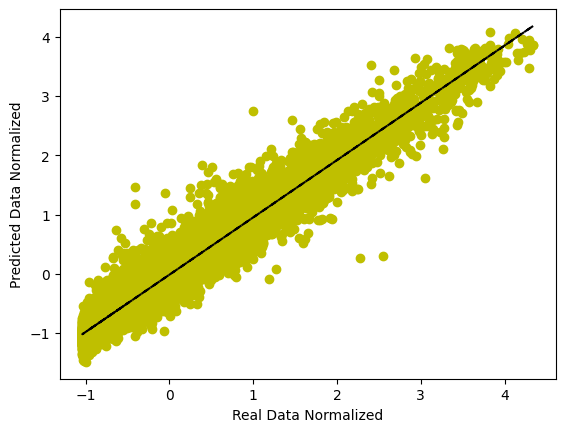

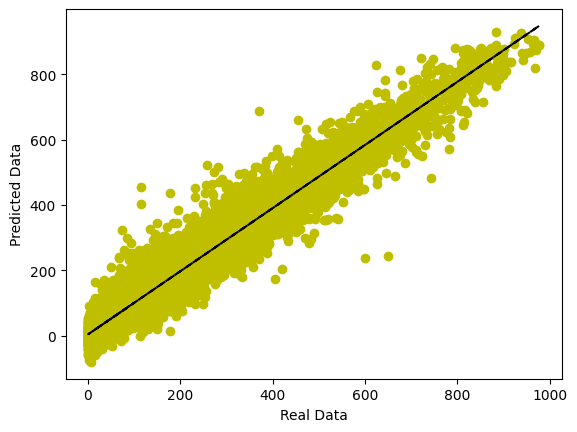

In [45]:
model.eval()

def get_prediction(values):
    tensor = torch.tensor(values)
    tensor = tensor.to(device)

    output = model.forward(tensor)
    probs = nn.functional.sigmoid(output)
    conf, = torch.max(probs, 1)
    return conf.item()

def denormalize_cnt(values):
    return np.float64(values) * original_data["cnt"]["std"] + original_data["cnt"]["mean"]

def scatter_plot(x, y, labels: tuple[str, str]):
    coef = np.polyfit(x, y, 1)
    poly1d_fn = np.poly1d(coef)
    plt.plot(x, y, "yo", x, poly1d_fn(x), "--k")
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])


pred_df = df[(df["yr"] == 0) | ((df["mnth_11"] == 0) & (df["mnth_12"] == 0))]
pred_dataset = MyDataset(pred_df, "cnt")
pred_data = DataLoader(
    pred_dataset,
    batch_size=64,
)


real_labels = []
predictions = []
for i, (inputs, target) in enumerate(pred_data):
    target = target.unsqueeze(1)
    inputs, target = inputs.to(device), target.to(device)

    output = model(inputs)
    predictions.extend(output.tolist())
    real_labels.extend(target.tolist())

real_labels = np.array(real_labels).flatten()
predictions = np.array(predictions).flatten()

mse = mean_squared_error(real_labels, predictions)
r2 = r2_score(real_labels, predictions)
print(f"""\
    \n\rMSE: {mse}\
    \n\rR^2: {r2}\
""")

cnt_predictions = denormalize_cnt(predictions).flatten()
real_cnt = denormalize_cnt(real_labels).flatten()
plt.subplots()
scatter_plot(real_labels, predictions, ("Real Data Normalized", "Predicted Data Normalized"))
plt.subplots()
scatter_plot(real_cnt, cnt_predictions, ("Real Data", "Predicted Data"))

# Mostrar la gráfica
plt.show()

### ¿Cómo fueron seleccionados los datos para predecir?
Fueron datos seleccionados del dataset. Fueron justamente aquellos que no se involucraron en su entrenamiento ni en su validación; todos los anteriores a los 2 últimos meses. Es decir, toda la información con la cual el modelo no tuvo la más mínima evaluación o entrenamiento.

### ¿Como se puede observar los valores predecidos del CNT?
Para obtener el valor de la predicción de CNT, se guardaron los valores de normalización (media y std), lográndose luego denormalizar la data con estos. El único problema es que si existe una predicción multiplicada por la std menor a la media, entonces su valor será negativo y, por tanto, inconsistente.

### ¿Cómo se desempeño?
Su $R^2$ score fue de apróx. 96% y su MSE score de 4% comparando los valores verdaderos con los predecidos. Dado que es una data real en la cual el modelo nunca interactuó, podríamos decir que es muy bueno prediciendo la cantidad de bicicletas dado todos los demás valores.